In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset,random_split
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time
import os
import copy
import wandb



In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 7
LEARNING_RATE = 0.01
EPOCHS_NUM = 15
wandb.init(
    project="resnet50-model",
    config={
        "batch_size": BATCH_SIZE,
        "num_classes": NUM_CLASSES,
        "learning_rate": LEARNING_RATE,
        "epochs": LEARNING_RATE,
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tetiana-trachuk-kn-2021 (tetiana-trachuk-kn-2021-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
device = torch.device('cpu')

augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

dataset = ImageFolder(root='C:/Diploma/classification_dataset', transform=augmentation_transforms)

train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transforms  # Update transform for the test dataset

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


print(f"Classes: {dataset.classes}")
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


Classes: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k']
Total samples: 14317
Training samples: 12169
Testing samples: 2148



Displaying first 10 samples from Training Dataset:
Label: 4, Class: 6. Benign Keratosis-like Lesions (BKL) 2624
Label: 1, Class: 10. Warts Molluscum and other Viral Infections - 2103
Label: 5, Class: 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Label: 0, Class: 1. Eczema 1677
Label: 1, Class: 10. Warts Molluscum and other Viral Infections - 2103
Label: 1, Class: 10. Warts Molluscum and other Viral Infections - 2103
Label: 1, Class: 10. Warts Molluscum and other Viral Infections - 2103
Label: 3, Class: 4. Basal Cell Carcinoma (BCC) 3323
Label: 3, Class: 4. Basal Cell Carcinoma (BCC) 3323
Label: 6, Class: 8. Seborrheic Keratoses and other Benign Tumors - 1.8k


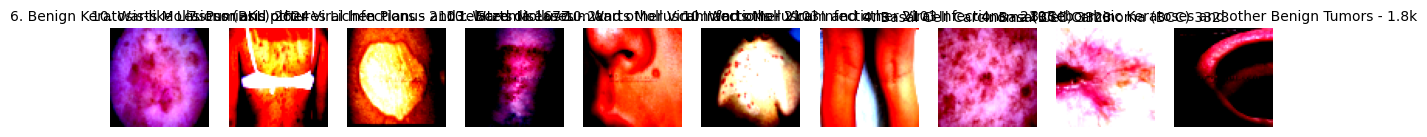

Displayed 10 images from Training Dataset.

Displaying first 10 samples from Testing Dataset:
Label: 6, Class: 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Label: 1, Class: 10. Warts Molluscum and other Viral Infections - 2103
Label: 2, Class: 3. Atopic Dermatitis - 1.25k
Label: 6, Class: 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Label: 4, Class: 6. Benign Keratosis-like Lesions (BKL) 2624
Label: 2, Class: 3. Atopic Dermatitis - 1.25k
Label: 6, Class: 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Label: 1, Class: 10. Warts Molluscum and other Viral Infections - 2103
Label: 0, Class: 1. Eczema 1677
Label: 3, Class: 4. Basal Cell Carcinoma (BCC) 3323


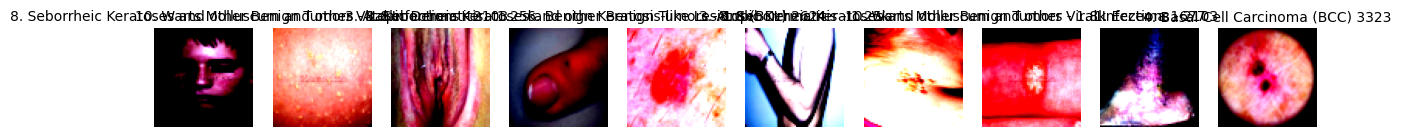

Displayed 10 images from Testing Dataset.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(dataset, title="Dataset Samples", num_samples=10):
    """Displays first `num_samples` images from the dataset with labels."""
    print(f"\nDisplaying first {num_samples} samples from {title}:")
    plt.figure(figsize=(15, 5))

    for i in range(num_samples):
        image, label = dataset[i]

        class_name = train_dataset.dataset.classes[label]

        print(f"Label: {label}, Class: {class_name}")

        img = image.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1) 

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.show()
    print(f"Displayed {num_samples} images from {title}.")

show_samples(train_dataset, title="Training Dataset", num_samples=10)
show_samples(test_dataset, title="Testing Dataset", num_samples=10)


In [ ]:
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, config.num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Diploma\Diploma\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Diploma\Diploma\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_accuracy = correct / total
        train_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss / len(train_loader),
            "Train Accuracy": train_accuracy,
            "Train Precision": train_precision,
            "Train Recall": train_recall,
            "Train F1 Score": train_f1
        })

        print(f"\nEpoch [{epoch+1}/{num_epochs}] - Loss: {train_loss/len(train_loader):.4f}, "
              f"Acc: {train_accuracy:.4f}, Precision: {train_precision:.4f}, "
              f"Recall: {train_recall:.4f}, F1: {train_f1:.4f}\n")


    return model

model = train_model(model, criterion, optimizer, EPOCHS_NUM)


Epoch [1/15] - Loss: 1.2583, Acc: 0.5179, Precision: 0.5114, Recall: 0.5179, F1: 0.5117


Epoch [2/15] - Loss: 0.8782, Acc: 0.6639, Precision: 0.6620, Recall: 0.6639, F1: 0.6615


Epoch [3/15] - Loss: 0.9143, Acc: 0.6545, Precision: 0.6529, Recall: 0.6545, F1: 0.6530


Epoch [4/15] - Loss: 0.7493, Acc: 0.7124, Precision: 0.7112, Recall: 0.7124, F1: 0.7110


Epoch [5/15] - Loss: 0.5130, Acc: 0.8089, Precision: 0.8085, Recall: 0.8089, F1: 0.8086


Epoch [6/15] - Loss: 0.3851, Acc: 0.8607, Precision: 0.8606, Recall: 0.8607, F1: 0.8606


Epoch [7/15] - Loss: 0.7538, Acc: 0.7301, Precision: 0.7291, Recall: 0.7301, F1: 0.7293


Epoch [8/15] - Loss: 0.4376, Acc: 0.8477, Precision: 0.8474, Recall: 0.8477, F1: 0.8475


Epoch [9/15] - Loss: 0.9483, Acc: 0.6278, Precision: 0.6247, Recall: 0.6278, F1: 0.6253


Epoch [10/15] - Loss: 0.6095, Acc: 0.7711, Precision: 0.7703, Recall: 0.7711, F1: 0.7705


Epoch [11/15] - Loss: 0.3629, Acc: 0.8716, Precision: 0.8714, Recall: 0.8716, F1: 0.8714


Epoch [

In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {len(train_dataset)} train images: {accuracy:.2f} %')

    wandb.log({"final_train_accuracy": accuracy})

Accuracy of the network on the 12169 train images: 97.12 %


In [9]:
torch.save(model.state_dict(), "classification_model_resnet.pth")
print("Model saved as 'classification_model_resnet.pth'")

wandb.finish()

Model saved as 'classification_model_resnet.pth'


Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▃▄▆▆▄▆▃▅▇▆▇██
Train F1 Score,▁▃▃▄▆▆▄▆▃▅▇▆▇██
Train Loss,█▆▆▅▃▃▅▃▆▄▂▃▂▁▁
Train Precision,▁▃▃▄▆▆▄▆▃▅▇▆▇██
Train Recall,▁▃▃▄▆▆▄▆▃▅▇▆▇██
final_train_accuracy,▁
Epoch,15
Train Accuracy,0.95308
Train F1 Score,0.95308
Train Loss,0.13459
